In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1) CONFIG / PARAMETERS
# ---------------------------------------------------
MODEL_PATH = "./models/total_consumption_lstm_model.keras"
SCALER_PATH = "./models/total_consumption_scaler.joblib"
CSV_PATH = "./agregated_hourly_2days.csv"  # CSV with at least the last 2 days
DATE_COL = "Date"                         # name of the datetime column
TARGET_COL = "total_consumption"          # main consumption column
SEQUENCE_LEN = 24        # the same window size used in training
FORECAST_HOURS = 24      # forecast horizon (day-ahead)

# 5 features in the LSTM (order must match training),
# but only 3 of them were scaled.
FEATURE_COLS = [
    "total_consumption",  # (scaled)
    "hour",               # (unscaled)
    "day_of_week",        # (unscaled)
    "lag1",               # (scaled)
    "rolling24"           # (scaled)
]

# We only scale these 3 columns:
SCALED_COLS = ["total_consumption", "lag1", "rolling24"]

# Indices of the scaled columns in FEATURE_COLS
SCALED_INDICES = [FEATURE_COLS.index(col) for col in SCALED_COLS]


# ---------------------------------------------------
# 2) HELPER FUNCTIONS FOR PARTIAL SCALING
# ---------------------------------------------------
def partial_transform(row_5, scaler):
    """
    row_5: [consumption, hour, day_of_week, lag1, rolling24] in original scale
    Returns a 5-element array where the consumption columns are scaled,
    and hour/day_of_week remain as is.
    """
    arr_3 = [
        row_5[SCALED_INDICES[0]],  # total_consumption
        row_5[SCALED_INDICES[1]],  # lag1
        row_5[SCALED_INDICES[2]],  # rolling24
    ]
    arr_3 = np.array(arr_3).reshape(1, -1) 
    scaled_3 = scaler.transform(arr_3)[0]

    out_5 = np.array(row_5, dtype=float)
    out_5[SCALED_INDICES[0]] = scaled_3[0]
    out_5[SCALED_INDICES[1]] = scaled_3[1]
    out_5[SCALED_INDICES[2]] = scaled_3[2]
    return out_5


def partial_inverse_transform(row_5_scaled, scaler):
    """
    row_5_scaled: [cons_scaled, hour, day_of_week, lag1_scaled, roll24_scaled]
    Returns a 5-element array in original scale.
    """
    arr_3_scaled = [
        row_5_scaled[SCALED_INDICES[0]],
        row_5_scaled[SCALED_INDICES[1]],
        row_5_scaled[SCALED_INDICES[2]],
    ]
    arr_3_scaled = np.array(arr_3_scaled).reshape(1, -1)
    arr_3_orig = scaler.inverse_transform(arr_3_scaled)[0]

    out_5_orig = np.array(row_5_scaled, dtype=float)
    out_5_orig[SCALED_INDICES[0]] = arr_3_orig[0]
    out_5_orig[SCALED_INDICES[1]] = arr_3_orig[1]
    out_5_orig[SCALED_INDICES[2]] = arr_3_orig[2]
    return out_5_orig


# ---------------------------------------------------
# 3) LOAD MODEL AND SCALER
# ---------------------------------------------------
print("Loading LSTM model...")
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

print("Loading MinMaxScaler...")
scaler = load(SCALER_PATH)
print("Scaler loaded successfully.\n")


# ---------------------------------------------------
# 4) READ CSV, CREATE FEATURES
# ---------------------------------------------------
data = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
data.sort_values(DATE_COL, inplace=True)
data.reset_index(drop=True, inplace=True)

print(f"Data loaded: {len(data)} records")
print("Latest rows:")
print(data.tail(3), "\n")

# Add hour, day_of_week
data["hour"] = data[DATE_COL].dt.hour
data["day_of_week"] = data[DATE_COL].dt.dayofweek

# Lag1 and rolling24 in original scale
data["lag1"] = data[TARGET_COL].shift(1)
data["rolling24"] = data[TARGET_COL].shift(1).rolling(24, min_periods=1).mean()

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

if len(data) < SEQUENCE_LEN:
    raise ValueError("Not enough rows for the 24-hour seed sequence.")

seed_df = data.iloc[-SEQUENCE_LEN:].copy()
consumption_history = list(seed_df[TARGET_COL])
last_timestamp = seed_df[DATE_COL].iloc[-1]

print("Seed DataFrame (last 24 rows):")
print(seed_df[[DATE_COL, TARGET_COL, "lag1", "rolling24"]].tail(3), "\n")


# ---------------------------------------------------
# 5) BUILD SEED SEQUENCE (SCALED)
#    We'll store the scaled consumption values for plotting
#    and to feed into the model.
# ---------------------------------------------------
seed_scaled_values = []
for i in range(len(seed_df)):
    row = seed_df.iloc[i]
    row_5_orig = [
        row["total_consumption"],
        row["hour"],
        row["day_of_week"],
        row["lag1"],
        row["rolling24"],
    ]
    row_5_scaled = partial_transform(row_5_orig, scaler)
    seed_scaled_values.append(row_5_scaled[0])  # store the scaled consumption separately

seed_array = []
for i in range(len(seed_df)):
    row = seed_df.iloc[i]
    row_5_orig = [
        row["total_consumption"],
        row["hour"],
        row["day_of_week"],
        row["lag1"],
        row["rolling24"],
    ]
    row_5_scaled = partial_transform(row_5_orig, scaler)
    seed_array.append(row_5_scaled)

seed_array = np.array(seed_array)  # shape (24,5)
current_sequence = seed_array.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

# We'll also track the **scaled consumption** from the last 24 hours
# so we can plot them on a scaled graph. 
# scaled_seed_consumption = seed_array[:,0]
scaled_seed_consumption = seed_array[:, 0]  # index 0 => 'total_consumption' in scaled form
seed_timestamps = seed_df[DATE_COL].values

print("Scaled seed consumption (first 5):", scaled_seed_consumption[:5], "\n")


# ---------------------------------------------------
# 6) FORECAST (24 hours) IN SCALED DOMAIN
# ---------------------------------------------------
scaled_predictions = []
predictions = []

for i in range(1, FORECAST_HOURS + 1):
    next_timestamp = last_timestamp + pd.Timedelta(hours=1)
    next_hour = next_timestamp.hour
    next_dow = next_timestamp.dayofweek

    # 'lag1' => last real or predicted consumption in original scale
    lag1_val = consumption_history[-1]
    rolling24_val = np.mean(consumption_history[-24:])

    # Build a dummy row in original scale
    dummy_next_orig = [0, next_hour, next_dow, lag1_val, rolling24_val]
    dummy_next_scaled = partial_transform(dummy_next_orig, scaler)

    # Shift sequence up by 1, add the new row
    seq_2d = current_sequence.reshape(SEQUENCE_LEN, len(FEATURE_COLS))
    seq_2d = np.vstack([seq_2d[1:], dummy_next_scaled])
    seq_3d = seq_2d.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

    # Predict scaled consumption
    y_pred_scaled = model.predict(seq_3d)
    y_pred_scaled = float(y_pred_scaled)
    scaled_predictions.append(y_pred_scaled)

    # Inverse to original for logging
    new_point_scaled = dummy_next_scaled.copy()
    new_point_scaled[0] = y_pred_scaled
    new_point_orig = partial_inverse_transform(new_point_scaled, scaler)
    pred_consumption = new_point_orig[0]

    # Insert the predicted scaled consumption into the final row
    final_point_scaled = dummy_next_scaled
    final_point_scaled[0] = y_pred_scaled

    # Update the LSTM sequence
    seq_2d = np.vstack([seq_2d[:-1], final_point_scaled])
    current_sequence = seq_2d.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

    consumption_history.append(pred_consumption)
    predictions.append((next_timestamp, pred_consumption))

    print(f"Predicted {next_timestamp} => scaled: {y_pred_scaled:.4f}, original: {pred_consumption:.2f}")

    last_timestamp = next_timestamp

# Convert lists to arrays for plotting
scaled_predictions = np.array(scaled_predictions)
forecast_timestamps = [seed_timestamps[-1] + pd.Timedelta(hours=i)
                       for i in range(1, FORECAST_HOURS+1)]


# ---------------------------------------------------
# 7) BUILD RESULTS DATAFRAME
# ---------------------------------------------------
forecast_df = pd.DataFrame(
    list(zip(forecast_timestamps, predictions)),
    columns=["Date", "PredictionTuple"]
)
forecast_df["Predicted_Consumption"] = forecast_df["PredictionTuple"].apply(lambda x: x[1])
forecast_df.drop("PredictionTuple", axis=1, inplace=True)

print("\nDAY-AHEAD FORECAST (scaled + original):")
print(forecast_df)


# ---------------------------------------------------
# 8) PLOT SCALED DATA
# ---------------------------------------------------
# We'll plot:
#  - last 24 hours of scaled consumption
#  - next 24 hours of scaled predictions
# on one continuous x-axis.

plt.figure(figsize=(10,5))

# Plot the seed (last 24h real) scaled
plt.plot(seed_timestamps, scaled_seed_consumption, label="Real (Scaled, last 24h)", marker="o")

# Plot the day-ahead predictions scaled
plt.plot(forecast_timestamps, scaled_predictions, label="Predicted (Scaled, next 24h)", marker="s")

plt.title("Day-Ahead Forecast (Scaled Domain)")
plt.xlabel("Timestamp")
plt.ylabel("Scaled Consumption")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1) CONFIG
# ---------------------------------------------------
MODEL_PATH = "./models/total_consumption_lstm_model.keras"
SCALER_PATH = "./models/total_consumption_scaler.joblib"
CSV_PATH = "./agregated_hourly_2days.csv"
DATE_COL = "Date"
TARGET_COL = "total_consumption"
SEQUENCE_LEN = 24
FORECAST_HOURS = 24

# Suppose we replaced 'hour' and 'day_of_week' with cyclical:
FEATURE_COLS = [
    "total_consumption",   # scaled
    "hour_sin",            # unscaled
    "hour_cos",            # unscaled
    "dow_sin",             # unscaled
    "dow_cos",             # unscaled
    "lag1",                # scaled
    "rolling24"            # scaled
]
SCALED_COLS = ["total_consumption", "lag1", "rolling24"]  # same partial-scaling as before

# Identify indices for scaled columns
SCALED_INDICES = [FEATURE_COLS.index(col) for col in SCALED_COLS]

# ---------------------------------------------------
# 2) HELPER FUNCTIONS
# ---------------------------------------------------
def partial_transform(row_vals, scaler):
    """
    row_vals: [cons, hour_sin, hour_cos, dow_sin, dow_cos, lag1, rolling24]
    Only scale indices for cons, lag1, rolling24.
    """
    arr_3 = [row_vals[SCALED_INDICES[0]],
             row_vals[SCALED_INDICES[1]],
             row_vals[SCALED_INDICES[2]]]  # e.g. total_consumption, lag1, rolling24
    arr_3 = np.array(arr_3).reshape(1, -1)
    scaled_3 = scaler.transform(arr_3)[0]

    out_vals = np.array(row_vals, dtype=float)
    out_vals[SCALED_INDICES[0]] = scaled_3[0]
    out_vals[SCALED_INDICES[1]] = scaled_3[1]
    out_vals[SCALED_INDICES[2]] = scaled_3[2]
    return out_vals

def partial_inverse_transform(row_scaled, scaler):
    arr_3_scaled = [
        row_scaled[SCALED_INDICES[0]],
        row_scaled[SCALED_INDICES[1]],
        row_scaled[SCALED_INDICES[2]],
    ]
    arr_3_scaled = np.array(arr_3_scaled).reshape(1, -1)
    arr_3_orig = scaler.inverse_transform(arr_3_scaled)[0]

    out_orig = np.array(row_scaled, dtype=float)
    out_orig[SCALED_INDICES[0]] = arr_3_orig[0]
    out_orig[SCALED_INDICES[1]] = arr_3_orig[1]
    out_orig[SCALED_INDICES[2]] = arr_3_orig[2]
    return out_orig

# ---------------------------------------------------
# 3) LOAD MODEL & SCALER
# ---------------------------------------------------
model = tf.keras.models.load_model(MODEL_PATH)
scaler = load(SCALER_PATH)

# ---------------------------------------------------
# 4) READ CSV, ADD CYCLICAL FEATURES
# ---------------------------------------------------
data = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
data.sort_values(DATE_COL, inplace=True)
data.reset_index(drop=True, inplace=True)

data["hour"] = data[DATE_COL].dt.hour
data["day_of_week"] = data[DATE_COL].dt.dayofweek

# cyclical encoding for hour (range 0..23)
data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)

# cyclical encoding for day_of_week (0..6)
data["dow_sin"] = np.sin(2 * np.pi * data["day_of_week"] / 7)
data["dow_cos"] = np.cos(2 * np.pi * data["day_of_week"] / 7)

# lag1 / rolling
data["lag1"] = data[TARGET_COL].shift(1)
data["rolling24"] = data[TARGET_COL].shift(1).rolling(24, min_periods=1).mean()
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

if len(data) < SEQUENCE_LEN:
    raise ValueError("Not enough rows for the 24-hour seed sequence.")

seed_df = data.iloc[-SEQUENCE_LEN:].copy()
consumption_history = list(seed_df[TARGET_COL])
last_timestamp = seed_df[DATE_COL].iloc[-1]

# ---------------------------------------------------
# 5) BUILD SEED SEQUENCE
# ---------------------------------------------------
def build_row_orig(df_row):
    return [
        df_row["total_consumption"],
        df_row["hour_sin"],
        df_row["hour_cos"],
        df_row["dow_sin"],
        df_row["dow_cos"],
        df_row["lag1"],
        df_row["rolling24"],
    ]

seed_array = []
for i in range(len(seed_df)):
    row_orig = build_row_orig(seed_df.iloc[i])
    row_scaled = partial_transform(row_orig, scaler)
    seed_array.append(row_scaled)

seed_array = np.array(seed_array)  # shape=(24,7)
current_seq = seed_array.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

# ---------------------------------------------------
# 6) FORECAST (24h, AUTOREGRESSIVE)
# ---------------------------------------------------
predictions = []
for i in range(1, FORECAST_HOURS+1):
    next_timestamp = last_timestamp + pd.Timedelta(hours=1)
    next_hour = next_timestamp.hour
    next_dow = next_timestamp.dayofweek

    # cyc enc
    next_hour_sin = np.sin(2 * np.pi * next_hour/24)
    next_hour_cos = np.cos(2 * np.pi * next_hour/24)
    next_dow_sin  = np.sin(2 * np.pi * next_dow/7)
    next_dow_cos  = np.cos(2 * np.pi * next_dow/7)

    # build dummy row in original scale
    lag1_val = consumption_history[-1]
    rolling24_val = np.mean(consumption_history[-24:])
    dummy_orig = [0, next_hour_sin, next_hour_cos, next_dow_sin, next_dow_cos, lag1_val, rolling24_val]

    dummy_scaled = partial_transform(dummy_orig, scaler)

    seq_2d = current_seq.reshape(SEQUENCE_LEN, len(FEATURE_COLS))
    seq_2d = np.vstack([seq_2d[1:], dummy_scaled])
    seq_3d = seq_2d.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

    y_pred_scaled = model.predict(seq_3d)
    y_pred_scaled = float(y_pred_scaled)

    # invert
    new_point_scaled = dummy_scaled.copy()
    new_point_scaled[0] = y_pred_scaled
    new_point_orig = partial_inverse_transform(new_point_scaled, scaler)
    pred_consumption = new_point_orig[0]

    # finalize
    final_scaled = dummy_scaled
    final_scaled[0] = y_pred_scaled
    seq_2d = np.vstack([seq_2d[:-1], final_scaled])
    current_seq = seq_2d.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

    consumption_history.append(pred_consumption)
    predictions.append((next_timestamp, pred_consumption))
    last_timestamp = next_timestamp
    print(f"{next_timestamp}: scaled={y_pred_scaled:.3f}, original={pred_consumption:.2f}")

# results
forecast_df = pd.DataFrame(predictions, columns=["Date","Predicted_Consumption"])
print(forecast_df.head(10))


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1) CONFIG
# ---------------------------------------------------
MODEL_PATH = "./models/total_consumption_lstm_final.keras"
SCALER_PATH = "./models/total_consumption_scaler.joblib"
CSV_PATH = "./agregated_hourly_2days.csv"
DATE_COL = "Date"
TARGET_COL = "total_consumption"
SEQUENCE_LEN = 24
FORECAST_HOURS = 24
BLOCK_SIZE = 6  # forecast 6 hours at a time, then refresh with real data

FEATURE_COLS = [
    "total_consumption",
    "hour",
    "day_of_week",
    "lag1",
    "rolling24"
]
SCALED_COLS = ["total_consumption","lag1","rolling24"]
SCALED_INDICES = [FEATURE_COLS.index(col) for col in SCALED_COLS]

# partial scaling
def partial_transform(row_5, scaler):
    arr_3 = [row_5[SCALED_INDICES[0]],
             row_5[SCALED_INDICES[1]],
             row_5[SCALED_INDICES[2]]]
    arr_3 = np.array(arr_3).reshape(1, -1)
    scaled_3 = scaler.transform(arr_3)[0]
    out_5 = np.array(row_5, dtype=float)
    out_5[SCALED_INDICES[0]] = scaled_3[0]
    out_5[SCALED_INDICES[1]] = scaled_3[1]
    out_5[SCALED_INDICES[2]] = scaled_3[2]
    return out_5

def partial_inverse_transform(row_5_scaled, scaler):
    arr_3_scaled = [row_5_scaled[SCALED_INDICES[0]],
                    row_5_scaled[SCALED_INDICES[1]],
                    row_5_scaled[SCALED_INDICES[2]]]
    arr_3_scaled = np.array(arr_3_scaled).reshape(1, -1)
    arr_3_orig = scaler.inverse_transform(arr_3_scaled)[0]
    out_5_orig = np.array(row_5_scaled, dtype=float)
    out_5_orig[SCALED_INDICES[0]] = arr_3_orig[0]
    out_5_orig[SCALED_INDICES[1]] = arr_3_orig[1]
    out_5_orig[SCALED_INDICES[2]] = arr_3_orig[2]
    return out_5_orig

# ---------------------------------------------------
# 2) LOAD MODEL & SCALER
# ---------------------------------------------------
model = tf.keras.models.load_model(MODEL_PATH)
scaler = load(SCALER_PATH)

# ---------------------------------------------------
# 3) READ CSV
# ---------------------------------------------------
data = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
data.sort_values(DATE_COL, inplace=True)
data.reset_index(drop=True, inplace=True)

data["hour"] = data[DATE_COL].dt.hour
data["day_of_week"] = data[DATE_COL].dt.dayofweek
data["lag1"] = data[TARGET_COL].shift(1)
data["rolling24"] = data[TARGET_COL].shift(1).rolling(24, min_periods=1).mean()
data.dropna(inplace=True)

if len(data) < SEQUENCE_LEN:
    raise ValueError("Not enough rows for the 24-hour seed sequence.")

seed_df = data.iloc[-SEQUENCE_LEN:].copy()
consumption_history = list(seed_df[TARGET_COL])
last_timestamp = seed_df[DATE_COL].iloc[-1]

def build_orig_row(df_row):
    return [
        df_row[TARGET_COL],
        df_row["hour"],
        df_row["day_of_week"],
        df_row["lag1"],
        df_row["rolling24"],
    ]

# Build the initial seed
seed_array = []
for i in range(len(seed_df)):
    row_vals = build_orig_row(seed_df.iloc[i])
    row_scaled = partial_transform(row_vals, scaler)
    seed_array.append(row_scaled)
seed_array = np.array(seed_array)
current_seq = seed_array.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

predictions = []
hours_forecasted = 0

# We'll do 24 hours total, in blocks of 6
while hours_forecasted < FORECAST_HOURS:
    # forecast up to the next block or remainder
    block_horizon = min(BLOCK_SIZE, FORECAST_HOURS - hours_forecasted)

    # forecast block_horizon hours
    for i in range(1, block_horizon+1):
        next_timestamp = last_timestamp + pd.Timedelta(hours=1)
        next_hour = next_timestamp.hour
        next_dow = next_timestamp.dayofweek

        lag1_val = consumption_history[-1]
        rolling24_val = np.mean(consumption_history[-24:])

        dummy_orig = [0, next_hour, next_dow, lag1_val, rolling24_val]
        dummy_scaled = partial_transform(dummy_orig, scaler)

        seq_2d = current_seq.reshape(SEQUENCE_LEN, len(FEATURE_COLS))
        seq_2d = np.vstack([seq_2d[1:], dummy_scaled])
        seq_3d = seq_2d.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

        y_pred_scaled = model.predict(seq_3d)
        y_pred_scaled = float(y_pred_scaled)

        # inverse
        new_point_scaled = dummy_scaled.copy()
        new_point_scaled[0] = y_pred_scaled
        new_point_orig = partial_inverse_transform(new_point_scaled, scaler)
        pred_consumption = new_point_orig[0]

        final_point_scaled = dummy_scaled
        final_point_scaled[0] = y_pred_scaled
        seq_2d = np.vstack([seq_2d[:-1], final_point_scaled])
        current_seq = seq_2d.reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))

        consumption_history.append(pred_consumption)
        predictions.append((next_timestamp, pred_consumption))
        last_timestamp = next_timestamp
        hours_forecasted += 1

    print(f"\nBlock forecast ended. Hours forecasted so far = {hours_forecasted}")
    
    # REFRESH with real data if available
    # e.g. in a real scenario, you might load new actual consumption rows from a sensor or database
    # Suppose you have new real data up to (next_timestamp) or next_timestamp-1. 
    # For demonstration, let's assume we do NOT have new real data. If you do, you'd do something like:
    # new_data = fetch_real_data(last_timestamp, block_horizon)
    # if new_data not empty:
    #     update 'consumption_history' and 'current_seq' with real rows
    #     ...
    # For now, we skip.


# Final
forecast_df = pd.DataFrame(predictions, columns=["Date","Predicted"])
print(forecast_df)


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Block complete → 8/24 hours predicted


C:\Users\user\AppData\Local\Temp\ipykernel_2292\4158221063.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scaled = float(model.predict(x_scaled, verbose=0))
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_2292\4158221063.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scaled = float(model.predict(x_scaled, verbose=0))
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: User

Block complete → 16/24 hours predicted


C:\Users\user\AppData\Local\Temp\ipykernel_2292\4158221063.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scaled = float(model.predict(x_scaled, verbose=0))
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_2292\4158221063.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scaled = float(model.predict(x_scaled, verbose=0))
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: User

Block complete → 24/24 hours predicted


C:\Users\user\AppData\Local\Temp\ipykernel_2292\4158221063.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scaled = float(model.predict(x_scaled, verbose=0))


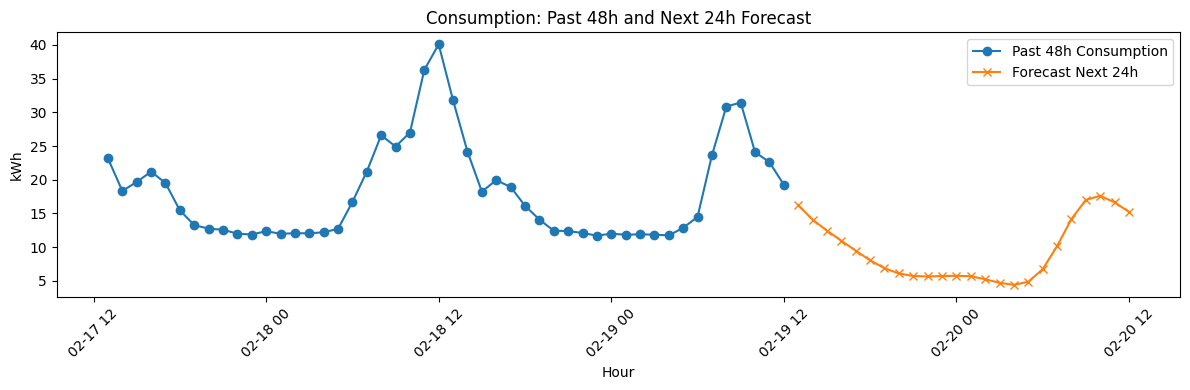

In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt
from collections import deque

# ---------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------
MODEL_PATH    = "models/total_consumption_lstm_final.keras"
SCALER_PATH   = "models/total_consumption_scaler.joblib"
CSV_PATH      = "api_data/hourly_building_consumption.csv"

DATE_COL      = "Hour"
TARGET_COL    = "Total_consumption"

SEQUENCE_LEN   = 24    # matches training SEQUENCE_LEN
FORECAST_HOURS = 24    # horizon to forecast
BLOCK_SIZE     = 8     # log progress every 8 hours
HIST_HOURS     = 48    # hours of past consumption to display

FEATURE_COLS = [
    "Total_consumption",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
    "lag1",
    "rolling24",
]

# Only these were scaled during training
SCALED_COLS    = ["Total_consumption", "lag1", "rolling24"]
SCALED_INDICES = [FEATURE_COLS.index(c) for c in SCALED_COLS]


def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """Add cyclic encodings, lag, and rolling mean features."""
    df = df_in.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek

    # cyclic hour & day-of-week
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # lag & rolling stats
    df["lag1"]      = df[TARGET_COL].shift(1)
    df["rolling24"] = df[TARGET_COL].shift(1).rolling(24, min_periods=1).mean()

    return df.dropna()


def partial_transform(row: list, scaler) -> np.ndarray:
    """Scale only the subset of columns in SCALED_COLS."""
    arr = np.array(row, dtype=float)
    sub = arr[SCALED_INDICES].reshape(1, -1)
    arr[SCALED_INDICES] = scaler.transform(sub)[0]
    return arr


def partial_inverse_transform(row_scaled: np.ndarray, scaler) -> np.ndarray:
    """Inverse scale only the subset of columns in SCALED_COLS."""
    arr = np.array(row_scaled, dtype=float)
    sub = arr[SCALED_INDICES].reshape(1, -1)
    arr[SCALED_INDICES] = scaler.inverse_transform(sub)[0]
    return arr


def load_and_prepare(csv_path: str) -> pd.DataFrame:
    """Load CSV with a datetime index, add features, and drop NaNs."""
    df = pd.read_csv(csv_path, parse_dates=[DATE_COL], index_col=DATE_COL)
    df = df.sort_index()
    df = add_features(df)
    return df


def forecast(model, scaler, data: pd.DataFrame) -> pd.DataFrame:
    """Run recursive forecasting and return a DataFrame of predictions."""
    if len(data) < SEQUENCE_LEN:
        raise ValueError(f"Need ≥{SEQUENCE_LEN} rows after feature engineering, got {len(data)}")

    # Seed history and sliding window
    seed    = data.iloc[-SEQUENCE_LEN:]
    history = deque(seed[TARGET_COL].tolist(), maxlen=SEQUENCE_LEN + FORECAST_HOURS)
    window  = deque(
        [partial_transform(r[FEATURE_COLS].tolist(), scaler) for _, r in seed.iterrows()],
        maxlen=SEQUENCE_LEN
    )
    last_ts = seed.index[-1]
    preds   = []

    for i in range(FORECAST_HOURS):
        next_ts = last_ts + pd.Timedelta(hours=1)

        # compute new features
        hr      = next_ts.hour
        dow     = next_ts.dayofweek
        hour_sin = np.sin(2 * np.pi * hr / 24)
        hour_cos = np.cos(2 * np.pi * hr / 24)
        dow_sin  = np.sin(2 * np.pi * dow / 7)
        dow_cos  = np.cos(2 * np.pi * dow / 7)

        lag1    = history[-1]
        roll24  = float(np.mean(list(history)[-24:]))

        # build and scale feature vector
        raw    = [0.0, hour_sin, hour_cos, dow_sin, dow_cos, lag1, roll24]
        scaled = partial_transform(raw, scaler)

        # model input
        x_scaled = np.array(window).reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))
        y_scaled = float(model.predict(x_scaled, verbose=0))

        # inverse-transform prediction
        scaled[0] = y_scaled
        y_orig    = partial_inverse_transform(scaled, scaler)[0]

        # update state
        history.append(y_orig)
        window.append(scaled)
        last_ts = next_ts
        preds.append((next_ts, y_orig))

        # log progress
        if (i + 1) % BLOCK_SIZE == 0 or (i + 1) == FORECAST_HOURS:
            print(f"Block complete → {i+1}/{FORECAST_HOURS} hours predicted")

    return pd.DataFrame(preds, columns=[DATE_COL, "Predicted_kWh"]).set_index(DATE_COL)


if __name__ == "__main__":
    # Load artefacts
    model  = tf.keras.models.load_model(MODEL_PATH)
    scaler = load(SCALER_PATH)

    # Sanity-check feature count
    exp_feats = model.input_shape[-1]
    if exp_feats != len(FEATURE_COLS):
        raise ValueError(
            f"Model expects {exp_feats} features, but FEATURE_COLS has {len(FEATURE_COLS)}"
        )

    # Prepare data & forecast
    df          = load_and_prepare(CSV_PATH)
    forecast_df = forecast(model, scaler, df)

    # Extract past two days of actual consumption
    past_consumption = df[TARGET_COL].iloc[-HIST_HOURS:]

    # Combine plotting of past consumption and forecast
    plt.figure(figsize=(12, 4))
    plt.plot(past_consumption.index, past_consumption.values, marker='o', label='Past 48h Consumption')
    plt.plot(forecast_df.index, forecast_df['Predicted_kWh'], marker='x', label='Forecast Next 24h')
    plt.title('Consumption: Past 48h and Next 24h Forecast')
    plt.xlabel(DATE_COL)
    plt.ylabel('kWh')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Block complete → 8/24 predicted


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Block complete → 16/24 predicted


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Block complete → 24/24 predicted

Forecast for 2025-02-20 (kWh):
2025-02-20 00:00: 27.76
2025-02-20 01:00: 29.41
2025-02-20 02:00: 31.91
2025-02-20 03:00: 34.72
2025-02-20 04:00: 37.86
2025-02-20 05:00: 39.53
2025-02-20 06:00: 40.80
2025-02-20 07:00: 42.13
2025-02-20 08:00: 43.37
2025-02-20 09:00: 42.48
2025-02-20 10:00: 35.04
2025-02-20 11:00: 22.23
2025-02-20 12:00: 12.02


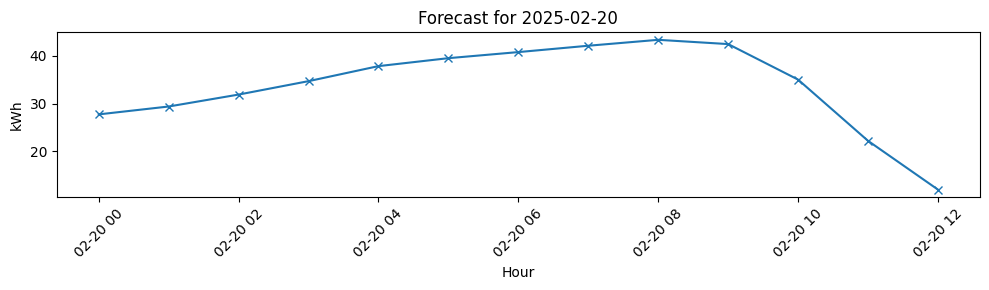

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt
from collections import deque
import holidays  # pip install holidays

# ---------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------
MODEL_PATH      = "models/final_workhours_model.keras"
SCALER_PATH     = "models/scaler_workhours.joblib"
CSV_PATH        = "api_data/hourly_building_consumption.csv"

DATE_COL        = "Hour"
TARGET_COL      = "Total_consumption"

SEQUENCE_LEN    = 10    # one workday
FORECAST_HOURS  = 24    # horizon to forecast
BLOCK_SIZE      = 8     # log progress every 8 hours
PAST_CYCLES     = 2     # number of workday cycles to display

FEATURE_COLS = [
    "Total_consumption", "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "lag1", "lag10", "lag50",
    "roll1", "roll10", "roll50",
    "time_delta",
    "is_month_start", "is_month_end", "is_holiday"
]

# Indices of features scaled during training
SCALED_COLS    = ["Total_consumption","lag1","lag10","lag50","roll1","roll10","roll50"]
SCALED_INDICES = [FEATURE_COLS.index(c) for c in SCALED_COLS]

# Swiss holiday calendar (adjust locale if needed)
HOL_CAL = holidays.Switzerland()

# ---------------------------------------------------
# Feature engineering functions
# ---------------------------------------------------
def add_features(df):
    df = df.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek

    # cyclic encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # lags & rolling stats
    df["lag1"]  = df[TARGET_COL].shift(1)
    df["lag10"] = df[TARGET_COL].shift(10)
    df["lag50"] = df[TARGET_COL].shift(50)

    df["roll1"]  = df[TARGET_COL].shift(1).rolling(1,  min_periods=1).mean()
    df["roll10"] = df[TARGET_COL].shift(1).rolling(10, min_periods=1).mean()
    df["roll50"] = df[TARGET_COL].shift(1).rolling(50, min_periods=1).mean()

    # irregular gap in hours
    df["time_delta"] = df.index.to_series().diff().dt.total_seconds().div(3600)

    # month & holiday flags
    df["is_month_start"] = df.index.is_month_start.astype(int)
    df["is_month_end"]   = df.index.is_month_end.astype(int)
    df["is_holiday"]     = df.index.normalize().isin(HOL_CAL).astype(int)

    return df.dropna()


def partial_transform(row, scaler):
    arr = np.array(row, dtype=float)
    sub = arr[SCALED_INDICES].reshape(1, -1)
    arr[SCALED_INDICES] = scaler.transform(sub)[0]
    return arr


def partial_inverse_transform(row, scaler):
    arr = np.array(row, dtype=float)
    sub = arr[SCALED_INDICES].reshape(1, -1)
    arr[SCALED_INDICES] = scaler.inverse_transform(sub)[0]
    return arr

# ---------------------------------------------------
# Load & prepare data
# ---------------------------------------------------
def load_and_prepare(csv_path):
    df = pd.read_csv(csv_path, parse_dates=[DATE_COL], index_col=DATE_COL)
    df = df.sort_index()
    # keep only Mon–Fri 08-17
    df = df[(df.index.dayofweek < 5) & (df.index.hour >= 8) & (df.index.hour <= 17)]
    return add_features(df)

# ---------------------------------------------------
# Recursive forecasting
# ---------------------------------------------------
def forecast(model, scaler, df):
    if len(df) < SEQUENCE_LEN:
        raise ValueError(f"Need ≥{SEQUENCE_LEN} rows, got {len(df)}")

    seed    = df.iloc[-SEQUENCE_LEN:]
    history = deque(seed[TARGET_COL].tolist(), maxlen=SEQUENCE_LEN + FORECAST_HOURS)
    window  = deque(
        [partial_transform(r[FEATURE_COLS].tolist(), scaler)
         for _, r in seed.iterrows()],
        maxlen=SEQUENCE_LEN
    )
    last_ts = seed.index[-1]
    preds   = []

    for i in range(FORECAST_HOURS):
        next_ts = last_ts + pd.Timedelta(hours=1)

        # feature computation
        hr, dow = next_ts.hour, next_ts.dayofweek
        raw = [
            0.0,
            np.sin(2*np.pi*hr/24), np.cos(2*np.pi*hr/24),
            np.sin(2*np.pi*dow/7), np.cos(2*np.pi*dow/7),
            history[-1],
            history[-10] if len(history)>=10 else history[0],
            history[-50] if len(history)>=50 else history[0],
            np.mean(list(history)[-1:]),
            np.mean(list(history)[-10:]) if len(history)>=10 else np.mean(history),
            np.mean(list(history)[-50:]) if len(history)>=50 else np.mean(history),
            (next_ts - last_ts).total_seconds()/3600,
            int(next_ts.is_month_start),
            int(next_ts.is_month_end),
            int(next_ts.normalize() in HOL_CAL)
        ]

        # scale and predict
        scaled = partial_transform(raw, scaler)
        x_in   = np.array(window).reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))
        y_scaled = model.predict(x_in, verbose=0).item()
        scaled[FEATURE_COLS.index(TARGET_COL)] = y_scaled
        y_orig = partial_inverse_transform(scaled, scaler)[0]

        # update state
        history.append(y_orig)
        window.append(scaled)
        last_ts = next_ts
        preds.append((next_ts, y_orig))

        # logging
        if (i+1)%BLOCK_SIZE==0 or (i+1)==FORECAST_HOURS:
            print(f"Block complete → {i+1}/{FORECAST_HOURS} predicted")

    return pd.DataFrame(preds, columns=[DATE_COL, "Predicted_kWh"]).set_index(DATE_COL)

# ---------------------------------------------------
# Main execution
# ---------------------------------------------------
if __name__ == "__main__":
    model  = tf.keras.models.load_model(MODEL_PATH)
    scaler = load(SCALER_PATH)

    # sanity check
    if model.input_shape[-1] != len(FEATURE_COLS):
        raise ValueError(f"Model expects {model.input_shape[-1]} features, but FEATURE_COLS has {len(FEATURE_COLS)}")

    df          = load_and_prepare(CSV_PATH)
    forecast_df = forecast(model, scaler, df)

    # select last N cycles
    past_len = PAST_CYCLES * SEQUENCE_LEN
    past = df[TARGET_COL].iloc[-past_len:]

    # print forecast values
    print("\n24-hour Forecast (kWh):")
    for ts, val in forecast_df['Predicted_kWh'].items():
        print(f"{ts}: {val:.2f}")

    # plotting
    plt.figure(figsize=(12,4))
    plt.plot(past.index, past.values, marker='o', label=f'Past {PAST_CYCLES} cycles')
    plt.plot(forecast_df.index, forecast_df.Predicted_kWh, marker='x', label='Next 24h Forecast')
    plt.title('Consumption: Last 2 Cycles & Next 24h Forecast')
    plt.xlabel(DATE_COL)
    plt.ylabel('kWh')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_8612\1830338924.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarn

Predicted 8/24 hours


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Predicted 16/24 hours


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Predicted 24/24 hours

Next‑day 24‑hour forecast (kWh):
                     Predicted_kWh
Hour                              
2025-04-16 00:00:00            NaN
2025-04-16 01:00:00            NaN
2025-04-16 02:00:00            NaN
2025-04-16 03:00:00            NaN
2025-04-16 04:00:00            NaN
2025-04-16 05:00:00            NaN
2025-04-16 06:00:00            NaN
2025-04-16 07:00:00            NaN
2025-04-16 08:00:00            NaN
2025-04-16 09:00:00            NaN
2025-04-16 10:00:00            NaN
2025-04-16 11:00:00            NaN
2025-04-16 12:00:00            NaN
2025-04-16 13:00:00            NaN
2025-04-16 14:00:00            NaN
2025-04-16 15:00:00            NaN
2025-04-16 16:00:00            NaN
2025-04-16 17:00:00            NaN
2025-04-16 18:00:00            NaN
2025-04-16 19:00:00            NaN
2025-04-16 20:00:00            NaN
2025-04-16 21:00:00            NaN
2025-04-16 22:00:00            NaN
2025-04-16 23:00:00            NaN
Saved forecast to next_day_forecas

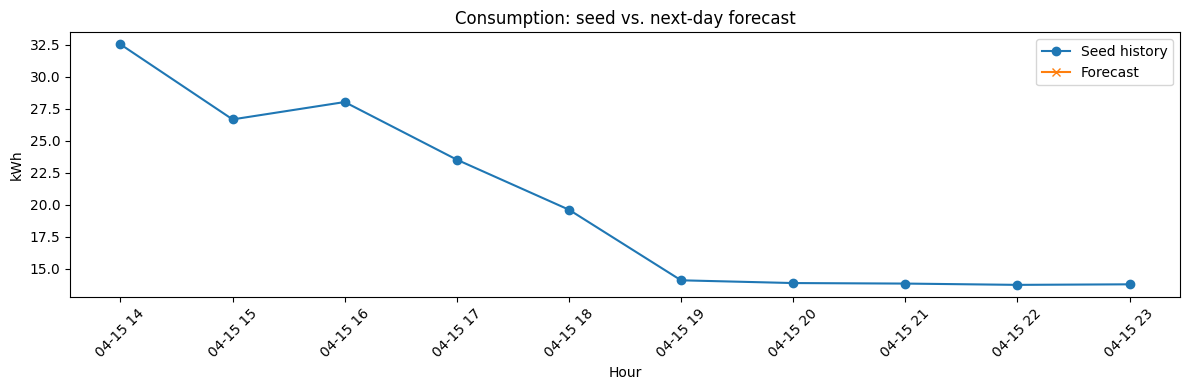

In [14]:
"""forecast_next_day.py
Forecast the next 24 workhours of building consumption using the pre‑trained LSTM.
Provide **two full days of raw hourly data** (48 rows) in a CSV with at least the
columns `Hour` (timestamp) and `Total_consumption` (kWh).  Adjust `csv_path` to
point to your file.

The script automatically adapts to the model’s sequence length and uses the
Belgian holiday calendar.
"""

# ---------------------------------------------------
# Imports & CONFIGURATION
# ---------------------------------------------------
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
from collections import deque
import matplotlib.pyplot as plt
import holidays  # pip install holidays

# <-- Set your CSV file here ---------------------------------------------
csv_path = "agregated_hourly_2days.csv"  # <- change to your path
# ------------------------------------------------------------------------

MODEL_PATH  = "models/final_workhours_model.keras"
SCALER_PATH = "models/scaler_workhours.joblib"

DATE_COL   = "Hour"
TARGET_COL = "Total_consumption"
FORECAST_HOURS = 24   # forecast horizon (workhours)
BLOCK_SIZE      = 8   # progress log step

FEATURE_COLS = [
    "Total_consumption", "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "lag1", "lag10", "lag50",
    "roll1", "roll10", "roll50",
    "time_delta",
    "is_month_start", "is_month_end", "is_holiday"
]
SCALED_COLS    = ["Total_consumption","lag1","lag10","lag50","roll1","roll10","roll50"]
SCALED_INDICES = [FEATURE_COLS.index(c) for c in SCALED_COLS]

# Belgian holidays
HOL_CAL = holidays.Belgium()

# ---------------------------------------------------
# Feature engineering helpers
# ---------------------------------------------------

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add the same engineered features used during model training.
    Missing lags/rolls are forward/back‑filled so that short histories still work."""
    df = df.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek

    # cyclic encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # causal lags & rolling stats
    df["lag1"]  = df[TARGET_COL].shift(1)
    df["lag10"] = df[TARGET_COL].shift(10)
    df["lag50"] = df[TARGET_COL].shift(50)

    df["roll1"]  = df[TARGET_COL].shift(1).rolling(1,  min_periods=1).mean()
    df["roll10"] = df[TARGET_COL].shift(1).rolling(10, min_periods=1).mean()
    df["roll50"] = df[TARGET_COL].shift(1).rolling(50, min_periods=1).mean()

    # irregular gap feature (hours since previous record)
    df["time_delta"] = df.index.to_series().diff().dt.total_seconds().div(3600)

    # calendar flags
    df["is_month_start"] = df.index.is_month_start.astype(int)
    df["is_month_end"]   = df.index.is_month_end.astype(int)
    df["is_holiday"]     = df.index.normalize().isin(HOL_CAL).astype(int)

    # fill the leading NaNs introduced by shifting/rolling so we keep rows
    df = df.fillna(method="bfill").fillna(method="ffill")
    return df


def partial_transform(row, scaler):
    arr = np.asarray(row, dtype=float)
    sub = arr[SCALED_INDICES].reshape(1, -1)
    arr[SCALED_INDICES] = scaler.transform(sub)[0]
    return arr


def partial_inverse(row, scaler):
    arr = np.asarray(row, dtype=float)
    sub = arr[SCALED_INDICES].reshape(1, -1)
    arr[SCALED_INDICES] = scaler.inverse_transform(sub)[0]
    return arr

# ---------------------------------------------------
# Forecast routine (recursive)
# ---------------------------------------------------

def forecast_next_day(model, scaler, df_engineered: pd.DataFrame) -> pd.DataFrame:
    _, seq_len, n_feat = model.input_shape

    if len(df_engineered) < seq_len:
        raise ValueError(f"Need at least {seq_len} rows after feature generation, got {len(df_engineered)}")

    # seed window & history
    seed = df_engineered.iloc[-seq_len:]
    history = deque(seed[TARGET_COL].tolist(), maxlen=seq_len + FORECAST_HOURS)
    window  = deque([partial_transform(r[FEATURE_COLS], scaler) for _, r in seed.iterrows()],
                    maxlen=seq_len)
    last_ts = seed.index[-1]
    preds = []

    for i in range(FORECAST_HOURS):
        next_ts = last_ts + pd.Timedelta(hours=1)
        hr, dow = next_ts.hour, next_ts.dayofweek

        raw = [
            0.0,  # placeholder for target
            np.sin(2*np.pi*hr/24), np.cos(2*np.pi*hr/24),
            np.sin(2*np.pi*dow/7), np.cos(2*np.pi*dow/7),
            history[-1],
            history[-10] if len(history) >= 10 else history[0],
            history[-50] if len(history) >= 50 else history[0],
            np.mean(list(history)[-1:]),
            np.mean(list(history)[-10:]) if len(history) >= 10 else np.mean(history),
            np.mean(list(history)[-50:]) if len(history) >= 50 else np.mean(history),
            (next_ts - last_ts).total_seconds() / 3600,
            int(next_ts.is_month_start),
            int(next_ts.is_month_end),
            int(next_ts.normalize() in HOL_CAL)
        ]

        scaled_row = partial_transform(raw, scaler)
        x_in = np.array(window).reshape(1, seq_len, n_feat)
        y_scaled = model.predict(x_in, verbose=0).item()
        scaled_row[FEATURE_COLS.index(TARGET_COL)] = y_scaled
        y_pred = partial_inverse(scaled_row, scaler)[0]

        # update state
        history.append(y_pred)
        window.append(scaled_row)
        last_ts = next_ts
        preds.append((next_ts, y_pred))

        if (i+1) % BLOCK_SIZE == 0 or i+1 == FORECAST_HOURS:
            print(f"Predicted {i+1}/{FORECAST_HOURS} hours")

    return pd.DataFrame(preds, columns=[DATE_COL, "Predicted_kWh"]).set_index(DATE_COL)

# ---------------------------------------------------
# Run forecast
# ---------------------------------------------------

def main():
    # 1. Load model & scaler
    model  = tf.keras.models.load_model(MODEL_PATH)
    scaler = load(SCALER_PATH)

    # 2. Read two‑day CSV
    raw_df = pd.read_csv(csv_path, parse_dates=[DATE_COL], index_col=DATE_COL)
    if raw_df.empty:
        raise ValueError(f"No data loaded from {csv_path}")

    # 3. Ensure chronological order and engineer features
    raw_df = raw_df.sort_index()
    df_engineered = add_features(raw_df)

    # 4. Forecast
    forecast_df = forecast_next_day(model, scaler, df_engineered)

    # 5. Display & save
    print("\nNext‑day 24‑hour forecast (kWh):")
    print(forecast_df)
    out_path = pathlib.Path(csv_path).with_name("next_day_forecast.csv")
    forecast_df.to_csv(out_path)
    print(f"Saved forecast to {out_path}")

    # 6. (Optional) Plot
    try:
        import matplotlib.pyplot as plt
        past = raw_df[TARGET_COL].tail(model.input_shape[1])
        plt.figure(figsize=(12,4))
        plt.plot(past.index, past.values, marker='o', label='Seed history')
        plt.plot(forecast_df.index, forecast_df.Predicted_kWh, marker='x', label='Forecast')
        plt.title('Consumption: seed vs. next‑day forecast')
        plt.xlabel(DATE_COL)
        plt.ylabel('kWh')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plotting skipped:", e)

if __name__ == "__main__":
    main()


In [15]:
"""next_day_predictor.py
=====================================================
Minimal script that takes **two days of hourly data** as a CSV *string* (so you
can paste it inline) and predicts the **next 24 hours** (00:00‑23:00) using the
pre‑trained LSTM + scaler.  Belgian holidays are honoured.

Steps
-----
1. Paste your 48‑row CSV into the `csv_data` triple‑quoted string.
2. Make sure `MODEL_PATH` and `SCALER_PATH` point to your trained artefacts.
3. Run the script → it prints a DataFrame for 16‑04‑2025 and writes
   `next_day_forecast.csv` next to the script.
"""

# ---------------------------------------------------
# Imports & paths
# ---------------------------------------------------
import io, pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import load
from collections import deque
import holidays

MODEL_PATH  = "models/final_workhours_model.keras"
SCALER_PATH = "models/scaler_workhours.joblib"
DATE_COL, TARGET_COL = "Hour", "Total_consumption"
FORECAST_HOURS = 24
BLOCK = 8

FEATURE_COLS = [
    "Total_consumption", "hour_sin", "hour_cos", "dow_sin", "dow_cos",
    "lag1", "lag10", "lag50", "roll1", "roll10", "roll50",
    "time_delta", "is_month_start", "is_month_end", "is_holiday"
]
SCALED_COLS    = ["Total_consumption","lag1","lag10","lag50","roll1","roll10","roll50"]
SCALED_IDX     = [FEATURE_COLS.index(c) for c in SCALED_COLS]
HOL_CAL        = holidays.Belgium()

# ---------------------------------------------------
# Paste your two‑day CSV here
# ---------------------------------------------------
csv_data = "agregated_hourly_2days.csv"

# ---------------------------------------------------
# Helper functions (same as training)
# ---------------------------------------------------

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["day_of_week"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["day_of_week"]/7)
    df["lag1"]  = df[TARGET_COL].shift(1)
    df["lag10"] = df[TARGET_COL].shift(10)
    df["lag50"] = df[TARGET_COL].shift(50)
    df["roll1"]  = df[TARGET_COL].shift(1).rolling(1,min_periods=1).mean()
    df["roll10"] = df[TARGET_COL].shift(1).rolling(10,min_periods=1).mean()
    df["roll50"] = df[TARGET_COL].shift(1).rolling(50,min_periods=1).mean()
    df["time_delta"] = df.index.to_series().diff().dt.total_seconds().div(3600)
    df["is_month_start"] = df.index.is_month_start.astype(int)
    df["is_month_end"]   = df.index.is_month_end.astype(int)
    df["is_holiday"]     = df.index.normalize().isin(HOL_CAL).astype(int)
    return df.fillna(method="bfill").fillna(method="ffill")

def p_transform(row, scaler):
    arr = np.asarray(row, float)
    arr[SCALED_IDX] = scaler.transform(arr[SCALED_IDX].reshape(1,-1))[0]
    return arr

def p_inverse(row, scaler):
    arr = np.asarray(row, float)
    arr[SCALED_IDX] = scaler.inverse_transform(arr[SCALED_IDX].reshape(1,-1))[0]
    return arr

# ---------------------------------------------------
# Forecast routine
# ---------------------------------------------------

def forecast_next_day(model, scaler, df_feat: pd.DataFrame) -> pd.DataFrame:
    _, seq_len, n_feat = model.input_shape
    if len(df_feat) < seq_len:
        raise ValueError(f"Need ≥{seq_len} rows, got {len(df_feat)}")
    seed = df_feat.iloc[-seq_len:]
    history = deque(seed[TARGET_COL].tolist(), maxlen=seq_len+FORECAST_HOURS)
    window  = deque([p_transform(r[FEATURE_COLS], scaler) for _,r in seed.iterrows()],
                    maxlen=seq_len)
    last_ts = seed.index[-1]
    out = []
    for i in range(FORECAST_HOURS):
        t = last_ts + pd.Timedelta(hours=1)
        hr,dow = t.hour, t.dayofweek
        row = [0.0,
               np.sin(2*np.pi*hr/24), np.cos(2*np.pi*hr/24),
               np.sin(2*np.pi*dow/7), np.cos(2*np.pi*dow/7),
               history[-1],
               history[-10] if len(history)>=10 else history[0],
               history[-50] if len(history)>=50 else history[0],
               np.mean(list(history)[-1:]),
               np.mean(list(history)[-10:]) if len(history)>=10 else np.mean(history),
               np.mean(list(history)[-50:]) if len(history)>=50 else np.mean(history),
               1.0,  # time delta is exactly 1h here
               int(t.is_month_start), int(t.is_month_end), int(t.normalize() in HOL_CAL)]
        scaled = p_transform(row, scaler)
        y_scaled = model.predict(np.array(window).reshape(1,seq_len,n_feat), verbose=0).item()
        scaled[FEATURE_COLS.index(TARGET_COL)] = y_scaled
        y_pred = p_inverse(scaled, scaler)[0]
        history.append(y_pred); window.append(scaled); last_ts = t
        out.append((t, y_pred))
        if (i+1) % BLOCK == 0 or i==FORECAST_HOURS-1:
            print(f"Predicted {i+1}/{FORECAST_HOURS} hrs")
    return pd.DataFrame(out, columns=[DATE_COL,"Predicted_kWh"]).set_index(DATE_COL)

# ---------------------------------------------------
# Main
# ---------------------------------------------------

def main():
    # 1. load artefacts
    model  = tf.keras.models.load_model(MODEL_PATH)
    scaler = load(SCALER_PATH)

    # 2. read pasted CSV
    df_raw = pd.read_csv(csv_data, parse_dates=[DATE_COL], index_col=DATE_COL)
    df_raw = df_raw.sort_index()
    df_feat = add_features(df_raw)

    # 3. forecast
    fc = forecast_next_day(model, scaler, df_feat)
    print("\n16‑04‑2025 forecast:")
    print(fc)
    fc.to_csv("next_day_forecast.csv")

if __name__ == "__main__":
    main()


C:\Users\user\AppData\Local\Temp\ipykernel_8612\1481602671.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="bfill").fillna(method="ffill")
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWa

Predicted 8/24 hrs


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Predicted 16/24 hrs


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but 

Predicted 24/24 hrs

16‑04‑2025 forecast:
                     Predicted_kWh
Hour                              
2025-04-16 00:00:00            NaN
2025-04-16 01:00:00            NaN
2025-04-16 02:00:00            NaN
2025-04-16 03:00:00            NaN
2025-04-16 04:00:00            NaN
2025-04-16 05:00:00            NaN
2025-04-16 06:00:00            NaN
2025-04-16 07:00:00            NaN
2025-04-16 08:00:00            NaN
2025-04-16 09:00:00            NaN
2025-04-16 10:00:00            NaN
2025-04-16 11:00:00            NaN
2025-04-16 12:00:00            NaN
2025-04-16 13:00:00            NaN
2025-04-16 14:00:00            NaN
2025-04-16 15:00:00            NaN
2025-04-16 16:00:00            NaN
2025-04-16 17:00:00            NaN
2025-04-16 18:00:00            NaN
2025-04-16 19:00:00            NaN
2025-04-16 20:00:00            NaN
2025-04-16 21:00:00            NaN
2025-04-16 22:00:00            NaN
2025-04-16 23:00:00            NaN
